# Using CNNs for MNIST Handwritten Digit Recognition

## Imports

In [33]:
# data analysis
import pandas as pd
# for linear algebra
import numpy as np
# plotting library
import matplotlib.pyplot as plt
%matplotlib inline
# Split the training data into train and validation sets
from sklearn.model_selection import train_test_split
# Evaluate our model
from sklearn.metrics import confusion_matrix

In [94]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [35]:
PATH = "../input/"
train_file = f'{PATH}train.csv'
test_file = f'{PATH}test.csv'
output_file = "submission.csv"

## Load Data

In [36]:
# Load the csv file using numpy
data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
# Split training data into train and valid sets
# First argument takes all the rows and all the columns after the first
# column(labels) and second argument takes the labels (i.e first column)
x_train, x_val, y_train, y_val = train_test_split(
    data[:,1:], data[:,0], test_size=0.1)

We need to reshape the data for Keras. Since, these images are not RGB, we only have one channel at the end.

In [37]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

Each of the images in the train and valid sets have pixel values between 0 and 255. We divide these by 255 to make all the values between 0 and 1.

In [38]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

We use One-hot encoding to convert the label values(orginally, between 0-9) to a 10x1 array where each label will have one "1" and nine "0"s where "1" tells us the value of the label. 

In [39]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Model

In [101]:
model = Sequential()

# Convolution layer with input image shape (28x28x1), relu activation, 
# kernel size of 3x3 and output image of size 16x16.
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
# Batch Normalization
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
# Drop 1/4th of the activations
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Dense(Fully Connected Layer) with output image of size 512x512
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# We use softmax because we have more than 2 output classes
model.add(Dense(10, activation='softmax'))

## Data Augmentation

In [102]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [103]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

We train once with a smaller learning rate to ensure convergence. We then speed things up, only to reduce the learning rate by 10% every epoch.

In [104]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [105]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=64),
                           steps_per_epoch=500,
                           epochs=20,
                           verbose=2,
                           validation_data=(x_val, y_val),
                           callbacks=[annealer])

Epoch 1/20
 - 17s - loss: 0.4799 - acc: 0.8468 - val_loss: 0.0831 - val_acc: 0.9743
Epoch 2/20
 - 14s - loss: 0.1603 - acc: 0.9502 - val_loss: 0.0555 - val_acc: 0.9836
Epoch 3/20
 - 14s - loss: 0.1203 - acc: 0.9638 - val_loss: 0.0551 - val_acc: 0.9845
Epoch 4/20
 - 14s - loss: 0.0989 - acc: 0.9708 - val_loss: 0.0421 - val_acc: 0.9893
Epoch 5/20
 - 14s - loss: 0.0878 - acc: 0.9734 - val_loss: 0.0425 - val_acc: 0.9888
Epoch 6/20
 - 14s - loss: 0.0829 - acc: 0.9747 - val_loss: 0.0421 - val_acc: 0.9886
Epoch 7/20
 - 14s - loss: 0.0742 - acc: 0.9783 - val_loss: 0.0319 - val_acc: 0.9912
Epoch 8/20
 - 14s - loss: 0.0671 - acc: 0.9791 - val_loss: 0.0336 - val_acc: 0.9912
Epoch 9/20
 - 14s - loss: 0.0640 - acc: 0.9813 - val_loss: 0.0314 - val_acc: 0.9926
Epoch 10/20
 - 14s - loss: 0.0589 - acc: 0.9825 - val_loss: 0.0300 - val_acc: 0.9921
Epoch 11/20
 - 14s - loss: 0.0556 - acc: 0.9836 - val_loss: 0.0292 - val_acc: 0.9929
Epoch 12/20
 - 14s - loss: 0.0491 - acc: 0.9847 - val_loss: 0.0305 - val_a

## Evaluate

In [106]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0234, final accuracy: 0.9940


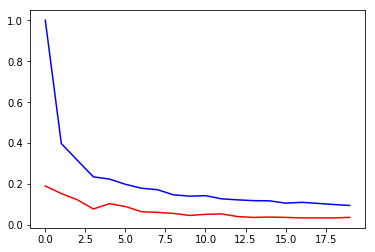

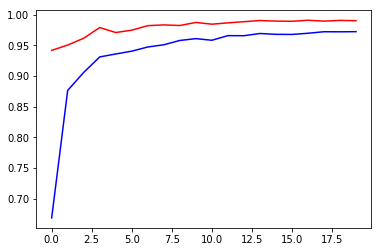

In [56]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [57]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[388   0   0   0   1   0   0   1   0   3]
 [  0 484   1   0   0   0   0   2   0   0]
 [  0   0 436   1   0   0   0   3   0   1]
 [  0   0   1 441   0   0   0   2   0   0]
 [  1   0   1   0 369   0   0   1   0   1]
 [  0   0   0   2   0 395   1   0   2   1]
 [  2   0   0   0   0   1 420   0   1   0]
 [  0   1   0   0   3   0   0 427   0   2]
 [  0   0   0   0   0   0   0   0 362   1]
 [  1   0   0   0   1   0   0   3   0 436]]


In [58]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

y_hat consists of class probabilities (corresponding to the one-hot encoding of the training labels).

In [59]:
y_hat = model.predict(x_test, batch_size=64)

Grab the maximum value from the array, corresponding to the number that has on-hot encoded value "1".

In [60]:
y_pred = np.argmax(y_hat,axis=1)

In [61]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))